In [11]:
import pandas as pd
import numpy as np
import re
import os 
import matplotlib.pyplot as plt
output_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'data', 'firing_rates'))
atlas_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'Analysis', 'atlas_data'))
import ssm 
from ssm.plots import gradient_cmap
import yaml
import itertools
import scipy
# workaround to get a specific version of scipy signaltools
def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered
import serotonin_functions
import seaborn as sns
sns.set_style("darkgrid")
from matplotlib.patches import Rectangle
from stim_functions import figure_style

In [2]:
# colors and color plates 

color_names = [
    "windows blue",
    "faded green"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [18]:
# functions

def load_firing_rates(output_dir, file_name):
    """
    Load data of firing rates
    output_dir: folder where the firing rates are saved
    Returns: Data Frame with state for all regions 
    """
    
    # load data 
    frate_E_sync = pd.read_csv(os.path.join(output_dir, f'frateE_{file_name}.csv'))
    frate_I_sync = pd.read_csv(os.path.join(output_dir, f'frateI_{file_name}.csv'))
    frate_A_sync = pd.read_csv(os.path.join(output_dir, f'frateA_{file_name}.csv')) 

    ratesG = np.array((frate_E_sync, frate_I_sync, frate_A_sync))
    return ratesG

def calc_HMM_states(firing_rate_I):
    '''
    Calculate the Up and down states of a time series
    '''
    
    # parameters for the HMM for finding Up and Down states 
    K = 2    # number of discrete states
    D = 1    # dimension of the observations

    # make an hmm and sample from it
    simple_hmm = ssm.HMM(K, D, observations='gaussian')

    # Fit HMM on all data
    trial_data = np.expand_dims(np.array(firing_rate_I), axis=1)
    lls = simple_hmm.fit(trial_data, method='em', transitions='sticky')
    posterior = simple_hmm.filter(trial_data)
    zhat = simple_hmm.most_likely_states(trial_data)
    # check if 1 and 0 state has to be turned around
    # so that 1 is up and 0 is down 
    if np.mean(trial_data[zhat==0]) > np.mean(trial_data[zhat==1]):
        zhat = np.where((zhat==0)|(zhat==1), zhat^1, zhat)
        p_down = posterior[:, 1]
    else:
        p_down = posterior[:, 0]
    
    return zhat, p_down

def get_all_states(output_dir, file_name, save_states=True):
    """
    Compute the up and down states for all of the regions in this session.
    output_dir: folder where the firing rates are saved
    file_name: name of the csv file, without the rate specification
    Returns: Data Frame with state for all regions 
    """
    
    # load data 
    regions_states = pd.DataFrame()
    frate_E_sync = pd.read_csv(os.path.join(output_dir, f'frateE_{file_name}.csv'))
    frate_I_sync = pd.read_csv(os.path.join(output_dir, f'frateI_{file_name}.csv'))
    frate_A_sync = pd.read_csv(os.path.join(output_dir, f'frateA_{file_name}.csv')) 

    ratesG = np.array((frate_E_sync, frate_I_sync, frate_A_sync))

    for i in range(ratesG.shape[2]):

        zhat, p_down = calc_HMM_states(ratesG[1, :, i])

        # safe the states in this dataframe
        regions_states = pd.concat((regions_states, pd.DataFrame(data={
        'state': zhat, 'p_down': p_down, 'region': i})))
    
    if save_states:
        regions_states.to_csv(os.path.join(output_dir, file_name+'_states.csv'))
    
    return regions_states


def plot_states_column(output_dir, file_name, stimulation=False):
    """
    Print the up and down state per region in one column 
    States: dataframe with state data
    Stimulation: wheter or not to also plot the serotonin stimulation on and offset.
    """
    
    # check if any files in the directory end with 'states.csv'
    if any(f.endswith('states.csv') for f in os.listdir(output_dir)):
        print('The folder contains a file with the ending "states.csv"')
    else:
        print('The folder does not contain a file with the ending "states.csv"')
        _ = get_all_states(output_dir, file_name)
        
    # load state data
    states = pd.read_csv(os.path.join(output_dir, file_name+'_states.csv'), index_col=0)
    
    # get the stimulation time file
    if stimulation:
        times_array = pd.read_csv(os.path.join(output_dir, file_name+'_stimulation_times.csv')).to_numpy() - start

    # load atlas with releveant regions for plotting
    atlas = pd.read_csv(os.path.join(atlas_dir, 'relevant_areas.csv'))
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)

    fig, axes = plt.subplots(len(atlas), 1, sharex=True, sharey=False, figsize=(9,10))
    frame = plt.gca()
    frame.axes.get_yaxis().set_visible(False)
    
    for i, ax in enumerate(axes):

        
        if stimulation:
            ax.plot(states[states['region']==i]['state'])
            for stim_time in times_array.flatten():
                ax.axvline(stim_time, color='red')
            
        else: 
            ax.plot(states[states['region']==i]['state'])
            
        ax.set_title(atlas[i][0], y=0, x=1.15)
    
    fig.suptitle(file_name, fontsize=15)
    plt.tight_layout()
    plt.show()


def plot_multiarea_signal(output_dir, file_name, start=None, stop=None, stimulation=False, states=False):
    """
    Plot the time series for multiple areas.
    output_dir: folder where the firing rates are saved
    file_name: name of the csv file, without the rate specification
    start, stop: beginning and end of plotting the signal
    stimulation: wheter or not to also plot the serotonin stimulation on and offset.
    states: if true, also plot HMM states
    """
    
    frate_E_sync = pd.read_csv(os.path.join(output_dir, f'frateE_{file_name}.csv'))
    frate_I_sync = pd.read_csv(os.path.join(output_dir, f'frateI_{file_name}.csv'))
    frate_A_sync = pd.read_csv(os.path.join(output_dir, f'frateA_{file_name}.csv')) 

    ratesG = np.array((frate_E_sync, frate_I_sync, frate_A_sync))
    
    # get the stimulation time file
    if stimulation:
        times_array = pd.read_csv(os.path.join(output_dir, file_name+'_stimulation_times.csv')).to_numpy() - start
    
    if states:
        # check if any files in the directory end with 'states.csv'
        if any(f.endswith('states.csv') for f in os.listdir(output_dir)):
            print('The folder contains a file with the ending "states.csv"')
        else:
            print('The folder does not contain a file with the ending "states.csv"')
            _ = get_all_states(output_dir, file_name)

        # load state data
        states_data = pd.read_csv(os.path.join(output_dir, file_name+'_states.csv'), index_col=0)
    
    # define the time window to plot
    start = 0 if not start else start
    stop = len(frate_I_sync) if not stop else stop
    
    # load atlas with releveant regions
    atlas = pd.read_csv(os.path.join(atlas_dir, 'relevant_areas.csv'))
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)
    fig, axes = plt.subplots(5, 3, sharex=True, sharey=False, figsize=(9,10))

    for i, ax in enumerate(axes.flatten()):
        
        if i > 10:
            ax.set_xlabel("time (ms)")
        if i==14:
            break

        ax.plot(ratesG[1,start:stop,i], label='I', color='#ff7f0e')
        ax.plot(ratesG[0,start:stop,i], label='E', color='#1f77b4')
        ax.set_title(atlas[i][0], fontsize=12)
        ax.legend()
        if i%3 == 0:
            ax.set_ylabel("firing rate (spike/s)")
        
        if stimulation:
            times_array_1 = times_array[:,0]
            times_array_2 = times_array[:,1]-2000
            
            for stim_time in np.concatenate((times_array_1, times_array_2)).flatten():
                ax.axvline(stim_time, color='red')
            
        if states:
            data = states_data[states_data['region']==i][start:stop].reset_index()
            ax.plot(data['state'], color='pink')
            lim = 1.05 * abs(ratesG[1,start:stop,i]).max()
            
            ax.imshow(np.expand_dims(data['state'], axis=0),
                       aspect="auto",
                       cmap=cmap,
                       #vmin=0,
                       #vmax=len(colors)-1,
                       extent=(0, len(ratesG[1,start:stop,i]), -2, lim))
    
    fig.suptitle(file_name, fontsize=15)
    plt.tight_layout()
    
    # safe the plots
    if states:
        plt.savefig(os.path.join(output_dir, file_name+ '_states.pdf'), transparent=False) 
    else:
        plt.savefig(os.path.join(output_dir, file_name+ '.pdf'), transparent=False)
    

def compute_brunel_x(output_dir, file_name):
    """
    Quantify synchrony of the network by computing the parameter X as defined in Brunel & Hansel (2006).
    """
    
    # get the session number (if file is part of several session)
    session = extract_session_nr(file_name)
    
    # load the activity for the inhibitory poputations
    _, ratesI, _ = load_firing_rates(output_dir, file_name)
    
    # get infos about session (for saving it later)
    G, S = extract_file_info(output_dir, file_name)
    
    # compute the variance of the population averaged activity
    network_rate_mean_pertime = np.mean(ratesI, axis=1)
    network_rate_mean_perregion = np.mean(ratesI, axis=0)

    # this is the same as np.var(network_rate_mean_pertime)
    network_variance = np.mean((network_rate_mean_pertime)**2) - np.mean(network_rate_mean_pertime)**2
    #print('network variance:', network_variance)

    # calculate the variance of each area individually 
    # the individual variance is completely independent of the other region's variance 
    individual_variance = np.mean((ratesI)**2) - np.mean(ratesI)**2

    # X parameter
    # if the average individual variance is similar to the overall regions variance 
    mean_individual_var = np.mean(individual_variance)
    #print('average of individual variance:', mean_individual_var)

    brunel_x = np.sqrt(network_variance/mean_individual_var)
    #print('synchrony:', brunel_x)
    
    return pd.DataFrame(data={'brunel_X' : brunel_x, 'G' : G, 'S' : S, 'session' : session}, index=[0])
    
    
def compute_state_analysis(output_dir, file_name):
    """
    File should be the From the data frame with state info calculate the most important parameter for every 
    region time series.
    G value, thetaE, beta, thetaE stimulation, serotonin stimulation times, and the most important parameters:
    Description of the parameters:
    f_s - frequency of states
    d_down - average duration of down-states
    d_up - average duration of up-states
    p_down - proportion time in state 0
    p_up - proportion time in state 1 
    brunel_X - quantifies synchrony: 0 low, 1 high
    """
    
    # check if it is a session
    session = extract_session_nr(file_name)
            
    # check if any files in the directory end with 'states.csv'
    if any(f.endswith(f'{session}_states.csv') for f in os.listdir(output_dir)):
        pass
    else:
        print('The folder does not contain a file with the ending "states.csv"')
        _ = get_all_states(output_dir, file_name)
        
        
    region_states = pd.read_csv(os.path.join(output_dir, f'{file_name}_states.csv'))
    state_statistics = pd.DataFrame()
    
    # get infos about session (for saving it later)
    G, S = extract_file_info(output_dir, file_name)

    # load atlas with releveant regions for plotting
    atlas = pd.read_csv(os.path.join(atlas_dir, 'relevant_areas.csv'))
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)
    
    for i, region in enumerate(np.unique(region_states['region'])):
    
        # get the time series for this region
        time_series = list(region_states[region_states['region']==region]['state'])
        trial_duration = len(time_series)

        # count the number of occurrences of 0 and 1
        num_zeros = time_series.count(0)
        num_ones = time_series.count(1)

        # calculate the duration of each state (in number of time steps)
        zero_durations = [sum(1 for _ in group) for key, group in itertools.groupby(time_series) if key == 0]
        one_durations = [sum(1 for _ in group) for key, group in itertools.groupby(time_series) if key == 1]
                
        # calculate the frequency of the states (I use the up-state here) 
        f_s = (len(one_durations)/trial_duration)*1000
        
        # calculate the average state durations 
        d_down = np.mean(zero_durations)
        d_up = np.mean(one_durations)

        # calculate the total duration of each state (in number of time steps)
        total_zero_duration = sum(zero_durations)
        total_one_duration = sum(one_durations)

        # calculate the proportion of time spent in each state
        prop_zero = total_zero_duration / len(time_series)
        prop_one = total_one_duration / len(time_series)

        # collect the values in the dataframe 
        state_statistics = pd.concat((state_statistics, pd.DataFrame(data={'state_frequency': f_s, 'd_down': d_down,
                                                                           'd_up' : d_up, 'p_down' : prop_zero,
                                                                           'p_up' : prop_one,
                                                                           'region' : atlas[i][0], 'G' : G, 'S' : S,
                                                                           'session': session}, index=[0])))
        
    return state_statistics

def extract_session_nr(filename):
    '''
    Extract the session number from the file name.
    '''
        
    pattern = r'sessions_(\d+)'

    # use re.search to find the first occurrence of the pattern in the filename
    match = re.search(pattern, filename)

    if match:
        session = match.group(1)
    else:
        session = None
        
    return session

     
def plot_session_statistics(state_statistics):
    """
    For one simulation session (with the same G and S value) plot the state statistics,
    so that makes one plot per parameter (e.g., frequency, average duration, ...).
    """

    # per parameter plot the values for each region
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8,9))

    sns.pointplot(state_statistics, x='region', y='state_frequency', ax=axes[0], join=False)
    sns.pointplot(state_statistics, x='region', y='d_up', ax=axes[1], join=False)
    sns.pointplot(state_statistics, x='region', y='d_down', ax=axes[2], join=False)
    axes[2].set_xticklabels(np.unique(state_statistics['region']), rotation = 90)
    for ax in axes:
        ax.label_outer()
    plt.show()


def plot_parameter_statistics(state_statistics, regions='all', size=[10, 5], savefig=False, filename_out=''):
    """
    For different G parameters plot all state parameters (e.g., frequency, average duration, ...)
    """

    if regions == 'all':
        plot_regions = np.unique(state_statistics['region'])
    else:
        plot_regions = np.unique(state_statistics[state_statistics['region'].isin(regions)]['region'])
        
    nr_regions = len(regions)
    fig, axes = plt.subplots(nr_regions, 3, sharex=True, sharey=False, figsize=size)
    
    for i, region in enumerate(plot_regions):

        region_stats = state_statistics[state_statistics['region']==region]

        axes[i][0].set_title('state_frequency', fontsize=18)
        sns.lineplot(x=region_stats['G'], y=region_stats['state_frequency'], ax=axes[i][0])
        axes[i][0].set_ylabel('Hz', fontsize=12)
        axes[i][0].set_xlabel('G', fontsize=12)
        
        axes[i][1].set_title(region+'\naverage state duration', fontsize=18)
        sns.lineplot(x=region_stats['G'], y=region_stats['d_down'], label='down', ax=axes[i][1])
        sns.lineplot(x=region_stats['G'], y=region_stats['d_up'], label='up', ax=axes[i][1])
        axes[i][1].set_ylabel('ms', fontsize=12)
        axes[i][1].set_xlabel('G', fontsize=12)
        axes[i][1].legend()

        axes[i][2].set_title('proportion of trial time', fontsize=18)
        sns.lineplot(x=region_stats['G'], y=region_stats['p_down'], label='down', ax=axes[i][2])
        sns.lineplot(x=region_stats['G'], y=region_stats['p_up'], label='up', ax=axes[i][2])
        axes[i][2].set_ylabel('percentage (%)', fontsize=12)
        axes[i][2].set_xlabel('G', fontsize=12)
        axes[i][2].legend()
        #plt.title(atlas[i][0], y=0, x=1.5) 
        
        for ax in axes[i]:
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(12)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(12) 
    if savefig:
        plt.savefig(f"state_analysis_{regions}{filename_out}.pdf", transparent=False, bbox_inches = 'tight')
    plt.tight_layout()

    
def get_stimulation_window(output_dir, file_name):
    """
    Get the start and stop time stamp of every stimulation window.
    """
    
    # get the stimulation time file
    stimulation_times = pd.read_csv(os.path.join(output_dir, file_name+'_stimulation_times.csv'))['0'].to_numpy()    
    groups = []
    for k, g in itertools.groupby(enumerate(stimulation_times), lambda i_x:i_x[0]-i_x[1]):
        group = list(map(lambda i_x:i_x[1], g))
        groups.append((group[0], group[-1]))

    times_array = np.array(groups)
    return times_array


def compute_stimulation_parameter(output_dir, file_name, session=""):
    """
    From the HMM state of a session, quantify the effect of serotonin stimulation on up and down states.
    For this we compute the duration until the next state change after start and stop of stimulation.
    session: if the simulation run is part of a session (so for example when I run 10 simulations with the same
                parameter) give the number of the session here to find the correct file.
    """
    
    # check if any files in the directory end with 'states.csv'
    if any(f.endswith(f'{session}_states.csv') for f in os.listdir(output_dir)):
        print('The folder contains a file with the ending "states.csv"')
    else:
        print('The folder does not contain a file with the ending "states.csv"')
        _ = get_all_states(output_dir, file_name)
    
    # get the stimulation start and stop values 
    times_array = pd.read_csv(os.path.join(output_dir, file_name+'_stimulation_times.csv')).to_numpy()
    state_data = pd.read_csv(os.path.join(output_dir, file_name+'_states.csv'), index_col=0)
    rates = load_firing_rates(output_dir, file_name)

    # get infos about session (for saving it later)
    G, S = extract_file_info(output_dir, file_name)

    # load atlas with releveant regions for plotting
    atlas = pd.read_csv(os.path.join(atlas_dir, 'relevant_areas.csv'))
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)

    # data frame to save the values
    stimulation_parameter = pd.DataFrame()

    for region in range(len(atlas)):

        region_state = state_data[state_data['region']==region]['state']

        for time_window in times_array:
            start = time_window[0]
            stop = time_window[1]
            
            # compute the average firing rate in this window
            meanI = np.mean(rates[1,start:stop,region])
            meanE = np.mean(rates[0,start:stop,region])

            # duration until next state after start
            start_state = region_state[start]
            for time_point, curr_state in enumerate(region_state[start:], start=start):
                if curr_state != start_state:
                    dur_next_start = time_point - start
                    break
            
            # duration until next state after stimulation end                
            stop_state = region_state[stop]
            dur_next_stop = None
            for time_point, curr_state in enumerate(region_state[stop:], start=stop):
                if curr_state != stop_state:
                    dur_next_stop = time_point - stop
                    break

            stimulation_parameter = pd.concat((stimulation_parameter, pd.DataFrame(data={'dur_next_start': dur_next_start,
                                                                     'start_state': start_state, 
                                                                     'dur_next_stop': dur_next_stop,
                                                                     'stop_state': stop_state, 
                                                                     'meanI': meanI, 'meanE': meanE,                     
                                                                     'region': atlas[region],
                                                                     'G': G, 'S': S, 'session':session}, index=[0])))
    return stimulation_parameter


def extract_file_info(output_dir, file_name):
    
    # load settingsfile 
    settings_file = os.path.join(output_dir, file_name+'_expsettings.yml')
    
    with open(settings_file, 'r', encoding='utf8') as f_in:
        settings = yaml.safe_load(f_in)
        
    G = settings['Parameter']['G']
    S = settings['Parameter']['S']
    
    return [G, S]


def compare_mean_stimulation(serotonin_excitatory_target, serotonin_inhibitory_target, G_vals, region):
    '''
    Plot the mean firing rate of the excitatory population and the inhibitory population for different Gs.
    We want to compare the difference between targeting the inhibitory population versus the excitatory population,
    therefore add the two datasets accordingly.
    serotonin_excitatory_target: dataset with stimulation analysis targeting excitatory population
    serotonin_inhibitory_target: dataset with stimulation analysis targeting inhibitory population
    G_vals: list of G values to plot
    region: region to plot (example: 'Tail of the striatum')
    '''
    
    # S on the x axis
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(8,5)) 

    region_data = serotonin_excitatory_target[serotonin_excitatory_target['region']==region]
    region_data_inhibit = serotonin_inhibitory_target[serotonin_inhibitory_target['region']==region]

    for i, G in enumerate(G_vals):
        Gdata = region_data[region_data['G']==G]
        Gdata_inhibit = region_data_inhibit[region_data_inhibit['G']==G]
        sns.lineplot(Gdata, x='S', y='meanI', ax=axes[1][i])
        sns.lineplot(Gdata_inhibit, x='S', y='meanI', ax=axes[1][i])

        if i == 1:
            sns.lineplot(Gdata, x='S', y='meanE', ax=axes[0][i], label='Estim')
            sns.lineplot(Gdata_inhibit, x='S', y='meanE', ax=axes[0][i], label='Istim')
        else:
            sns.lineplot(Gdata, x='S', y='meanE', ax=axes[0][i])
            sns.lineplot(Gdata_inhibit, x='S', y='meanE', ax=axes[0][i])   

        axes[0][i].set_title(f'G = {G}')

    fig.suptitle(region, fontsize=15)
    plt.tight_layout()
    
    
def plot_mean_stimulation(stimulation_analysis_file, region, G_values, savefig=False):
    '''
    Plot the mean firing rate (E and I) during serotonin stimulation for different G (different graphs in one plot) 
    and S values (on the x axis).
    Parameter:
    stimulation_analysis_file: file with meanE and meanI values 
    '''
    sns.set_style('darkgrid')
    serotonin_params = pd.read_csv(f"{stimulation_analysis_file}.csv")
    # average over the serotonin stimulation windows (within for example 20 sec there might be 3 or 4 stimulation phases)
    serotonin_params = serotonin_params.groupby(['S', 'G', 'session', 'region'], as_index=False).agg({'meanI':'mean',
                                                                    'meanE':'mean'})
    # S on the x axis
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(5,5))

    region_data = serotonin_params[serotonin_params['region']==region]
    plot_data = region_data[region_data['G'].isin(G_values)]
    
    sns.lineplot(plot_data, x='S', y='meanI', hue='G', ax=axes[1])
    sns.lineplot(plot_data, x='S', y='meanE', hue='G', ax=axes[0])
    axes[1].set_xlabel('S (serotonin stimulation strength)', fontsize=10)
    axes[1].set_ylabel('average rate I pop.', fontsize=10)
    axes[0].set_ylabel('average rate E pop.', fontsize=10)
    fig.suptitle(region, fontsize=15)
    plt.tight_layout()
    if savefig:
        plt.savefig(f'{stimulation_analysis_file}_{region}.pdf', transparent = False)
        
        
def plot_compare_stimTarget(fileE, fileI, region, G_params, S_params, savefig=False):
    """
    We want to see if targeting the inhibitory population (with a +current) has the same effect 
    as targeting the excitatory population (with a -current).
    region: region as string
    G_params: the G parameter that we want to plot     
    """
    
    # load the data 
    serotonin_params = pd.read_csv(fileE)
    serotonin_params_inhibit = pd.read_csv(fileI)
    
    # S on the x axis
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(8,5))

    # select the region and S values
    region_data = serotonin_params[serotonin_params['region']==region]
    region_data = region_data[region_data['S'].isin(S_params)]
    region_data_inhibit = serotonin_params_inhibit[serotonin_params_inhibit['region']==region]
    region_data_inhibit = region_data_inhibit[region_data_inhibit['S'].isin(S_params)]
    
    for i, G in enumerate(G_params):
        Gdata = region_data[region_data['G']==G]
        Gdata_inhibit = region_data_inhibit[region_data_inhibit['G']==G]
        sns.lineplot(Gdata, x='S', y='meanI', ax=axes[1][i])
        sns.lineplot(Gdata_inhibit, x='S', y='meanI', ax=axes[1][i])

        if i == 1:
            sns.lineplot(Gdata, x='S', y='meanE', ax=axes[0][i], label='Estim')
            sns.lineplot(Gdata_inhibit, x='S', y='meanE', ax=axes[0][i], label='Istim')
        else:
            sns.lineplot(Gdata, x='S', y='meanE', ax=axes[0][i])
            sns.lineplot(Gdata_inhibit, x='S', y='meanE', ax=axes[0][i])   

        axes[0][i].set_title(f'G = {G}')

    fig.suptitle(region, fontsize=15)
    plt.tight_layout()
    if savefig:
        plt.savefig(f'stimulationTarget_IvsE_{region}.jpg', transparent = False)
        

def compute_transitions(G_params, S_params, regions, window_length, pre_stim, sessions, thetaE=-1, beta=6, extra=''):
    ''' 
    For each window of serotonin stimulation, calculate the downstate probability and state change probablility.
    G_params: list of G parameter 
    S_params: list of S parameter 
    region: brain region
    window_length: length of window around stimulation onset
    pre_stim: time to plot before stimulation onset (subtracted from entire window in the end)
    '''
    
    times = np.arange(-pre_stim, window_length-pre_stim, 1)
    all_windows = pd.DataFrame()
    state_trans_df = pd.DataFrame()
    sessions = sessions 
    state_all_windows = pd.DataFrame()


    for S in S_params:
        for G in G_params:
            p_state_change_all = []
           
            session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_sessions' 
            for session in sessions:
                
                for region in regions:
                
                    file_dir = os.path.join(output_dir, session_name)
                    file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_sessions_{session}'
                    states = pd.read_csv(os.path.join(file_dir, file_name+'_states.csv'), index_col=0)
                    states_region = states[states['region']==region]
                    # get the time window around the stimulation 
                    times_array = pd.read_csv(os.path.join(file_dir, file_name+'_stimulation_times.csv')).to_numpy()

                    # first check if all time windows are big enough 
                    # (e.g., sometimes the last simulation is too close to the end of the trial)
                    windows = []
                    for win in times_array:
                        start = win[0] - pre_stim
                        state_window = states_region[start:start+window_length]
                        if len(state_window) == window_length:
                            windows.append(start)


                    for i, start in enumerate(windows):
                        state_window = states_region[start:start+window_length]

                        # the state changes
                        zhat = state_window['state']
                        #print('zhat', zhat[145:155])
                        state_change_up = np.concatenate((np.diff(zhat) > 0, [False])).astype(int)
                        state_change_down = np.concatenate((np.diff(zhat) < 0, [False])).astype(int)

                        state_all_windows = pd.concat((state_all_windows, pd.DataFrame(data={'session': session, 'window': i, 'p_down':state_window['p_down'],
                                                                                 'p_state_change_up': state_change_up, 'p_state_change_down': state_change_down,
                                                                                 'time':times, 'state':zhat,
                                                                                 'region':region, 'G' : G, 'S' : S})))
                    
            
    # take the mean over all individual windows in one session 
    #state_all_windows = state_all_windows.groupby(['region', 'S', 'session', 'G', 'time'], as_index=False).mean()
    
    # add the names of the regions to the dataset
    # for this load the atlas with releveant regions for plotting
    atlas = pd.read_csv(os.path.join(atlas_dir, 'relevant_areas.csv'))
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)
    state_all_windows['region_name'] = atlas[np.array(state_all_windows['region'].values, dtype=int)]
    
    return state_all_windows 


def plot_downstate_prob(data, S, G_params, region, savefig=False, fileout=''):
    """
    Plot the probability of the down state.
    data: transition data of sessions. The stimulation windows are 
    """
    sns.set_style("darkgrid")
    fig, axes = plt.subplots(len(G_params), 1, sharex=True, sharey=False, figsize=(8,5))

    # load atlas with releveant regions for plotting
    atlas = pd.read_csv(os.path.join(atlas_dir, 'relevant_areas.csv'))
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)

    for i, G in enumerate(G_params):
        print(G)
        axes[i].axvspan(0, 1000, alpha=0.1, color='royalblue')
        axes[i].set_xlim(-150, 1350)
        axes[i].plot([-150, 1350], [0.5, 0.5], ls='--', color='grey')
        Gdata = data[data['G']==G]
        data_grouped = Gdata.groupby(['session', 'S', 'time'], as_index=False).mean('p_down')
        data_grouped_S = data_grouped[data_grouped['S'].isin(S)]
        sns.lineplot(data_grouped_S, x='time', y='p_down', hue='S', ax=axes[i], palette='deep')
        axes[i].set_title(f'G = {G}', fontsize=10)
    
    fig.suptitle(f'{atlas[region][0]} - downstate probability during stimulation (S={S}) period', fontsize=15)
    if savefig:
        plt.savefig(f'transition_{atlas[region][0]}_p_down_S{S}{fileout}.pdf', transparent=False, bbox_inches = 'tight')
        

def plot_statechange_prob(transition_data, bin_size, S, G_plot, pre_stim, savefig=False):
    """
    Put the state change probability (which is one value per ms) into bins and plots this.
    Also plots when the serotonin stimulation is taking place.
    transition_data: data that contains the transition change probabilty per ms, for one region. Use the 
    bin_size: how many ms per bin
    """
    
    # get the region data
    #transition_data = transition_data[transition_data['region']==region]
    
    # find how many sessions & windows there are in this set and how long one session is 
    nr_sessions = len(np.unique(transition_data['session']))
    #print('sessions', nr_sessions)
    max_time = len(np.unique(transition_data['time']))
    nr_bins = max_time/bin_size
    bins = np.linspace(-pre_stim, max_time-pre_stim, int(nr_bins), endpoint=False)
    #print('max time', max_time)
    #print('bins', bins )

    # load atlas with releveant regions for plotting
    atlas = pd.read_csv(os.path.join(atlas_dir, 'relevant_areas.csv'))
    atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
    atlas = np.array(atlas)

    digitized = np.digitize(np.unique(transition_data['time']), bins, right=True)
    print('digitized shape', digitized.shape)
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(8,5))

    for i, G in enumerate(G_plot):
        axes[i].axvspan(0, 1000, alpha=0.1, color='royalblue')
        axes[i].set_xlim(-pre_stim, max_time-pre_stim)
        Gdata = transition_data[transition_data['G']==G]
        Sdata = Gdata[Gdata['S']==S]
        print(len(Sdata))
        
        windows_total = 0
        for session in range(nr_sessions):
            #print('session', session)
            session_df = Sdata[Sdata['session'] == session]
            nr_windows = len(np.unique(session_df['window']))
            #print('Number windows', nr_windows)
            windows_total = windows_total + nr_windows
            
        #print('windows total', windows_total)
        Sdata['bin'] = np.tile(digitized, windows_total)
        data_grouped_bins = Sdata.groupby(['session', 'bin'], as_index=False).mean()
        sns.lineplot(data_grouped_bins, x='time', y='p_state_change_up', ax=axes[i], label='up')
        sns.lineplot(data_grouped_bins, x='time', y='p_state_change_down', ax=axes[i], label='down')
        axes[i].set_ylabel('prob. state change')
        axes[i].legend()
        axes[i].set_title(f'G = {G}')

    if savefig:
        plt.savefig(f'prob_state_change_{atlas[region][0]}_S{S}.pdf', transparent=False, bbox_inches = 'tight')    

#### Multi area model  
Extended single ara model, replicated from Jercog et al. 2017

In [ ]:
file_name_add = '_5areas'
frate_E = pd.read_csv(os.path.join(output_dir, f'frateE{file_name_add}.csv'))
frate_I = pd.read_csv(os.path.join(output_dir, f'frateI{file_name_add}.csv'))
frate_A = pd.read_csv(os.path.join(output_dir, f'frateA{file_name_add}.csv'))

file_name_add = '_5areas_G1'
frate_E_sync = pd.read_csv(os.path.join(output_dir, f'frateE{file_name_add}.csv'))
frate_I_sync = pd.read_csv(os.path.join(output_dir, f'frateI{file_name_add}.csv'))
frate_A_sync = pd.read_csv(os.path.join(output_dir, f'frateA{file_name_add}.csv'))

In [ ]:
# make a multidim array with all the firing rates
rates = np.array((frate_E, frate_I, frate_A))
ratesG = np.array((frate_E_sync, frate_I_sync, frate_A_sync))

In [ ]:
# plot in a row all rates and adaptation trajectories

fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(10,14))

for i, ax in enumerate(axes):
    ax[0].plot(rates[0,:,i], label='E', )
    ax[0].plot(rates[1,:,i], label='I')
    ax[1].plot(rates[2,:,i], label='A', color='black')
    ax[0].legend() 
    ax[1].legend() 
    
plt.savefig('5areas_G-0.pdf')
plt.show()

In [ ]:
# plot in a row all rates and adaptation trajectories

fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(12,14))

for i, ax in enumerate(axes):
    ax[0].plot(ratesG[0,:,i], label='E', )
    ax[0].plot(ratesG[1,:,i], label='I')
    ax[1].plot(ratesG[2,:,i], label='A', color='black')
    ax[0].legend() 
    ax[1].legend() 
    
plt.savefig('5areas_G-1_Cmatrix-1.pdf')

In [ ]:
# looping over nd array
test = np.array((np.arange(5), np.arange(5, 10), np.arange(10, 15), np.arange(15, 20), np.arange(20, 25)))
np.fill_diagonal(test, 0)
test_b = np.zeros((5,5))
test_b[2][1] = 11 # to area 2 from area 1 it is connected with the strength 11
rate_example = np.array([1, 10, 25, 2, 5])
print(rate_example.shape)

In [ ]:
# this is to calculate the influence of area 1 on area 2
# it computes the value for area 2 
np.matmul(test_b, rate_example)

### Multi area 
14 areas, connected with allen brain atlas data

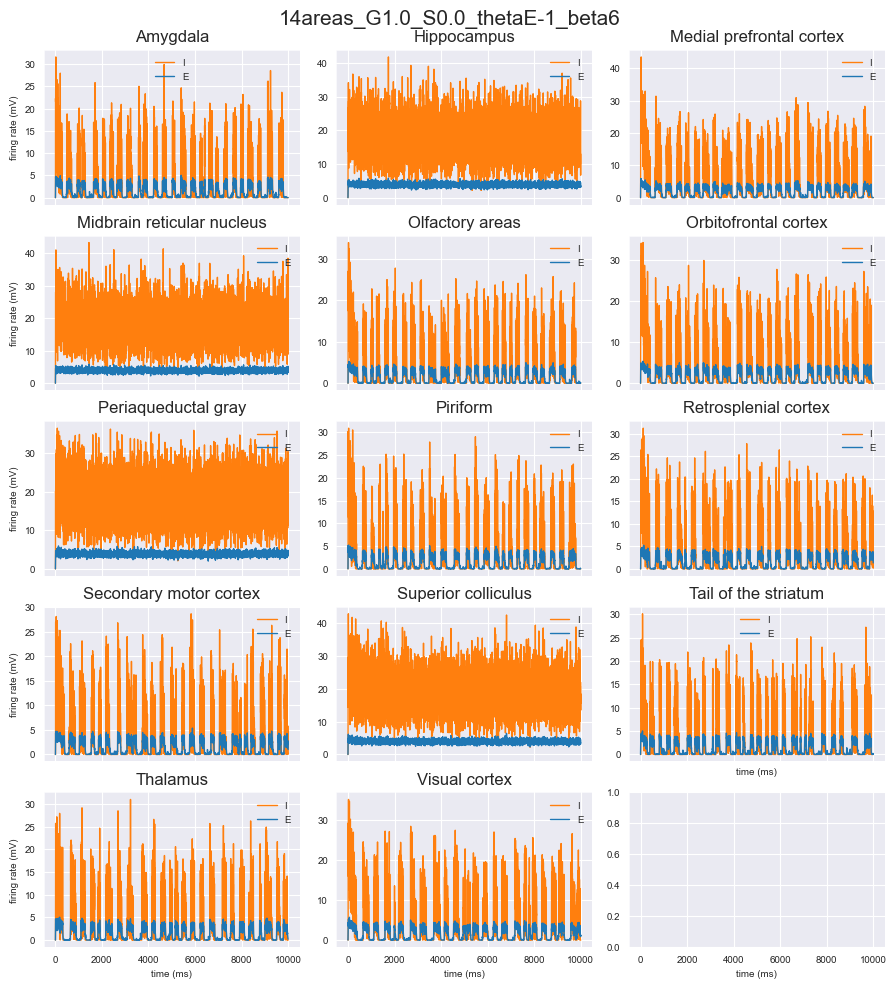

In [624]:
# plot signal of all regions for one simulation session
G = 1
S = 0
beta = 6
thetaE = -1
extra = ""
start = 0
stop = 5000
file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
file_dir = os.path.join(output_dir, file_name)
plot_multiarea_signal(file_dir, file_name, start, stimulation=False)

The folder contains a file with the ending "states.csv"


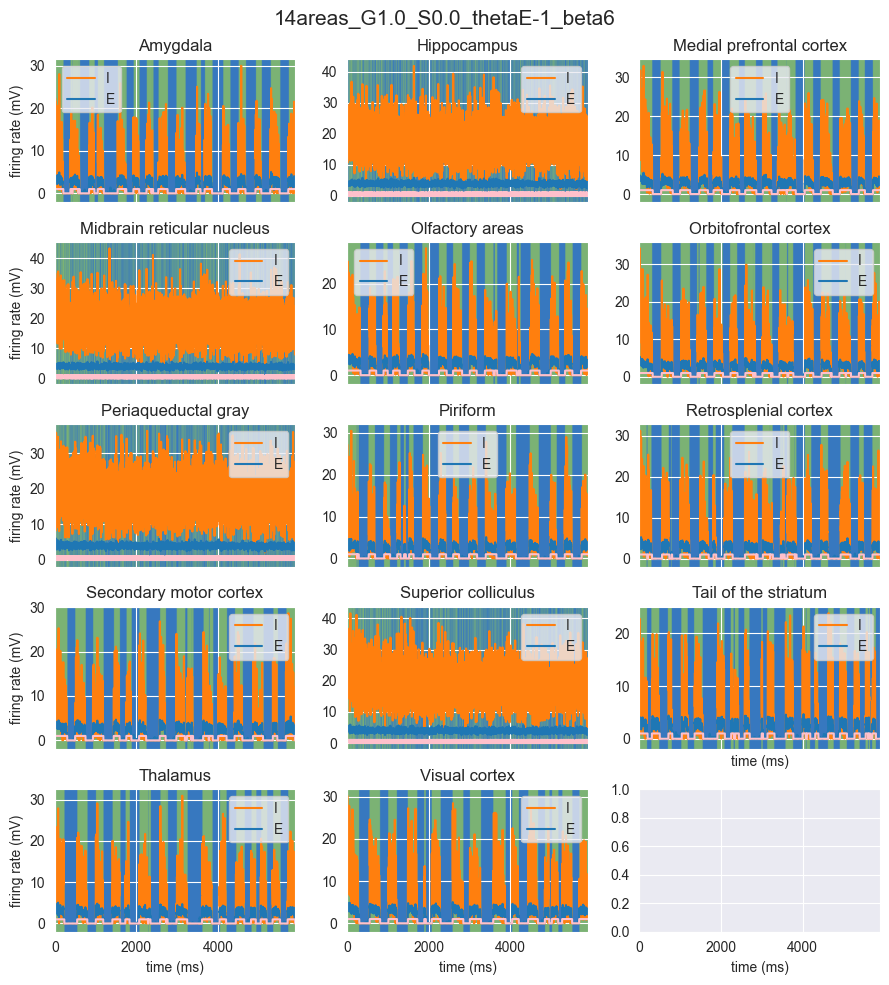

In [5]:
# compute the states of all regions and plot it together with the signal 
start = 100
stop = 6000
plot_multiarea_signal(file_dir, file_name, start, stop, states=True)

The folder contains a file with the ending "states.csv"


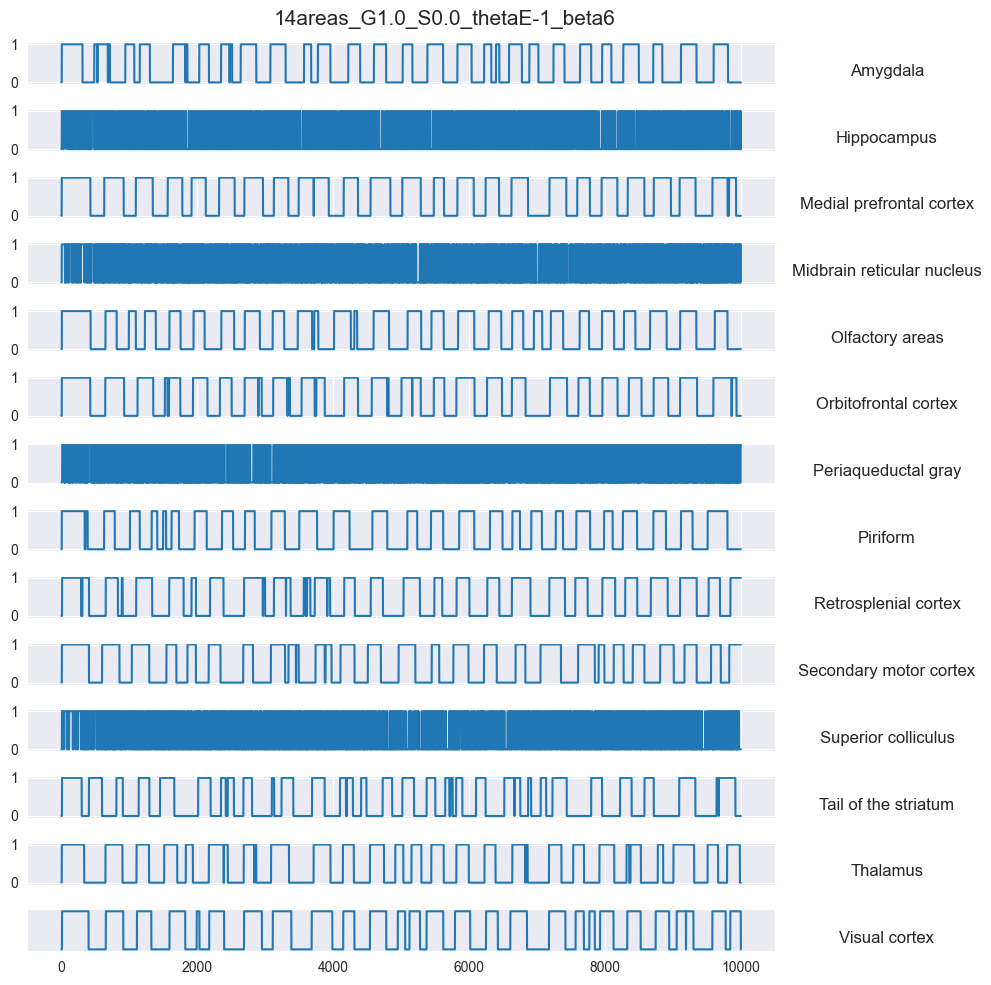

In [6]:
# plot the states of all regions in a column on top of each other
plot_states_column(file_dir, file_name)


The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

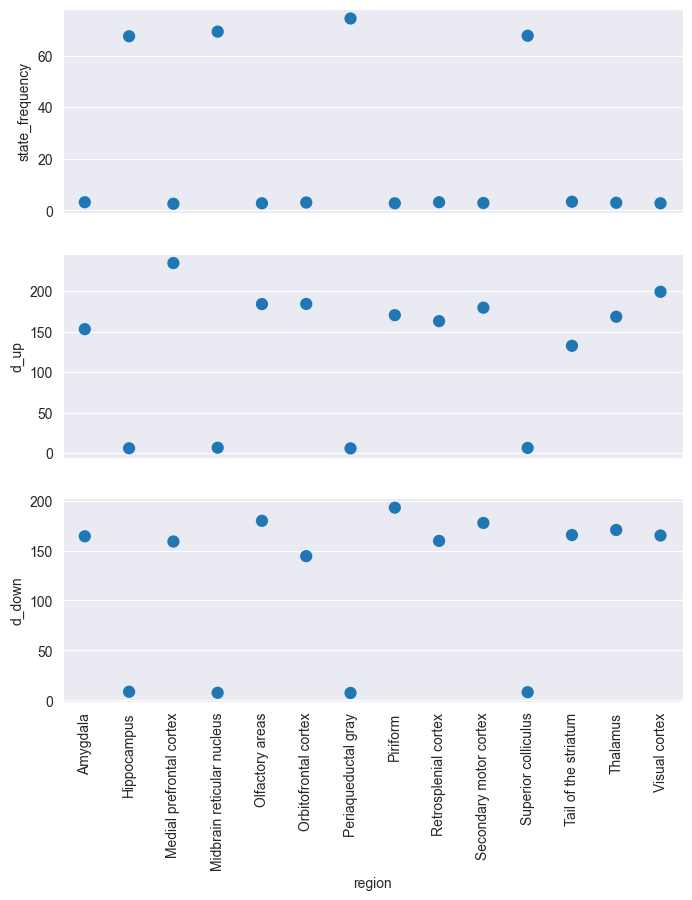

   brunel_X    G    S session
0  0.318168  1.0  0.0    None


In [7]:
# compute the analysis of the states 
state_statistics = compute_state_analysis(file_dir, file_name)
plot_session_statistics(state_statistics)
print(compute_brunel_x(file_dir, file_name))

In [8]:
# calculate the states and synchrony quantification (brunel X parameter) for many different G values 
G_parameters = np.arange(0, 9, 0.5)
all_analyses = pd.DataFrame()
brunel_X_df = pd.DataFrame()
for G in G_parameters:
    G_param = np.round(G, 1)
    file_name = f'14areas_G{G_param}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
    file_dir = os.path.join(output_dir, file_name)
    #_ = get_all_states(file_dir, file_name)
    brunel_X_df = pd.concat((brunel_X_df, compute_brunel_x(file_dir, file_name)))
    all_analyses = pd.concat((all_analyses, compute_state_analysis(file_dir, file_name)))

The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# choose one region and for this region plot the different parameter for different G values 
plot_parameter_statistics(all_analyses, regions=['Amygdala', 'Medial prefrontal cortex', 'Tail of the striatum'],
                          size=[15,10])

In [ ]:
# plot the brunel X for different G params
sns.lineplot(brunel_X_df, x='G', y='brunel_X')

## Serotonin Stimulation

In [ ]:
# plot the current connectivity
drn = pd.read_csv('drn_connectivity_cre-True_hemi-3_grouping-median_thresh-0.005.csv')
atlas = pd.read_csv(os.path.join(atlas_dir, 'relevant_areas.csv'))
atlas.drop(['Unnamed: 0'], inplace=True, axis=1)
atlas = np.array(atlas)
fig, ax = plt.subplots(figsize=(0.5,5))   
sns.heatmap(drn, yticklabels=np.squeeze(atlas), square=False, ax=ax, vmin=-0.01, vmax= 0.2)


In [ ]:
# load data
# plot signal of all regions for one simulation session
G = 0
S = 90
beta = 6
thetaE = -1
extra = "InhibitoryPop"
start = 0
stop = 7000
file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
file_dir = os.path.join(output_dir, file_name)
plot_multiarea_signal(file_dir, file_name, start, states=False, stimulation=True)

In [ ]:
# choose one simulation session and plot the states of all regions in a column on top of each other
G = 0
S = 90
beta = 6
thetaE = -1
extra = "InhibitoryPop"
file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
file_dir = os.path.join(output_dir, file_name)
#_ = get_all_states(file_dir, file_name)
plot_states_column(file_dir, file_name, stimulation=True)

Interesting parameters of serotonin stimulation:
- duration until next down state after stimulation start
- duration until next up state after stimulation end
- synchrony within the stimulation window 

In [ ]:
# compute the paramters of serotonin stimulation for different G and S values
G_params = np.arange(1, 5) # [1, 2, 3, 4, 5, 6] #np.arange(0, 10, 1)
S_params = np.arange(10,100,10) # [10, 20, 30, 40, 50, 60, 70] #np.arange(0, 100, 10)
serotonin_params = pd.DataFrame()
extra = ""

for G in G_params:
    for S in S_params:
        # load the file name
        file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
        file_dir = os.path.join(output_dir, file_name)
        serotonin_params = pd.concat((serotonin_params, compute_stimulation_parameter(file_dir, file_name)))
        

# plot the mean firing rate during the stimulation time
# S on the x axis
G_plot = [1, 2, 3, 4, 5, 6]
fig, axes = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(5,5))

region = 'Tail of the striatum' 

region_data = serotonin_params[serotonin_params['region']==region]

sns.lineplot(region_data, x='S', y='meanI', hue='G', ax=axes[1])
sns.lineplot(region_data, x='S', y='meanE', hue='G', ax=axes[0])

fig.suptitle(region, fontsize=15)
plt.tight_layout()

In [ ]:
# calculate the states and synchrony quantification (brunel X parameter) for many different G values 
G_parameters = np.arange(1, 10, 1)
S_parameters = [0, 1, 1.5, 2]
all_analyses = pd.DataFrame()
brunel_X_df = pd.DataFrame()

for G in G_parameters:
    G_param = np.round(G, 1)
    
    for S in S_parameters:
        S_param = np.round(S, 1)
        file_name = f'14areas_G{float(G_param)}_S{float(S_param)}_thetaE{thetaE}_beta{beta}{extra}'
        file_dir = os.path.join(output_dir, file_name)
        
        # if there is no file containing the HMM states, compute them first
        # check if any files in the directory end with 'states.csv'
        if any(f.endswith('states.csv') for f in os.listdir(file_dir)):
            pass
            #print('The folder contains a file with the ending "states.csv"')
        else:
            print('The folder does not contain a file with the ending "states.csv"')
            _ = get_all_states(file_dir, file_name)

        brunel_X_df = pd.concat((brunel_X_df, compute_brunel_x(file_dir, file_name)))
        all_analyses = pd.concat((all_analyses, compute_state_analysis(file_dir, file_name)))


## Plot several sessions
Since there is noise in the simulation, it is important to run several simulations with the same parameter settings.

<AxesSubplot:xlabel='region', ylabel='state_frequency'>

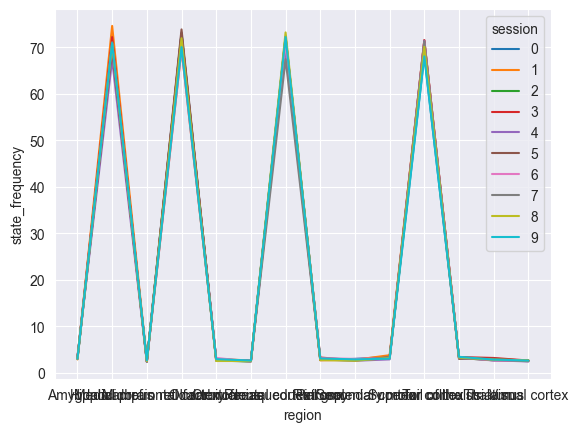

In [10]:
# for a test, look at the different sessions within one simulation 
G_param = 1
S_param = 10
extra = '_'
session_dir = f'14areas_G{float(G_param)}_S{float(S_param)}_thetaE{thetaE}_beta{beta}{extra}sessions'
sessions = np.arange(0, 10)
session_data = pd.DataFrame()

for session in sessions:
    session_name = f'14areas_G{float(G_param)}_S{float(S_param)}_thetaE{thetaE}_beta{beta}{extra}sessions_{session}'
    session_dir = os.path.join(output_dir, session_dir)
    session_data = pd.concat((session_data, compute_state_analysis(session_dir, session_name)))
    
# x axis will look messy because its the name of the regions, but this is only a small test to check if the sessions are kind of
# similar
sns.lineplot(session_data, x='region', y='state_frequency', hue='session')

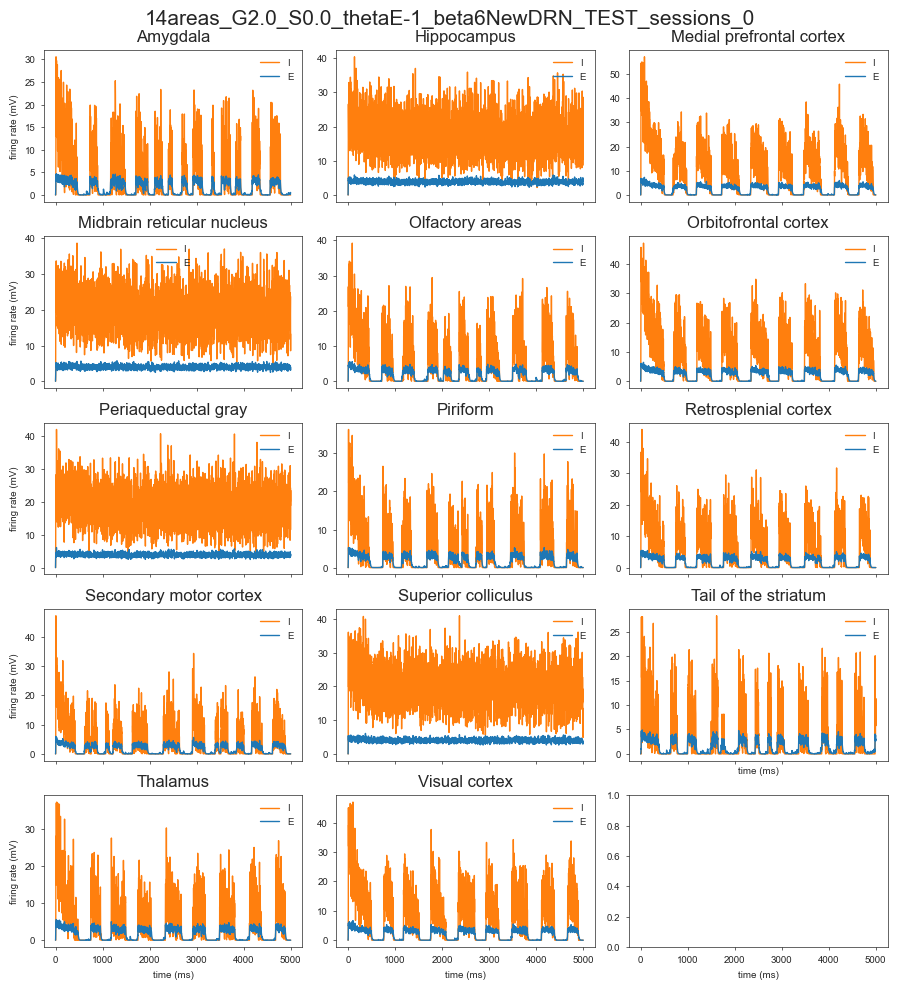

In [61]:
# plot one session 
# plot signal of all regions for one simulation session
session = 0
G = 2
S = 0 #160
beta = 6
thetaE = -1
extra = "NewDRN_TEST"
start = 0
stop = 5000
file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_sessions'
file_dir = os.path.join(output_dir, file_name)
file_name = file_name + f'_{session}'
plot_multiarea_signal(file_dir, file_name, start, stop, states=False, stimulation=False)

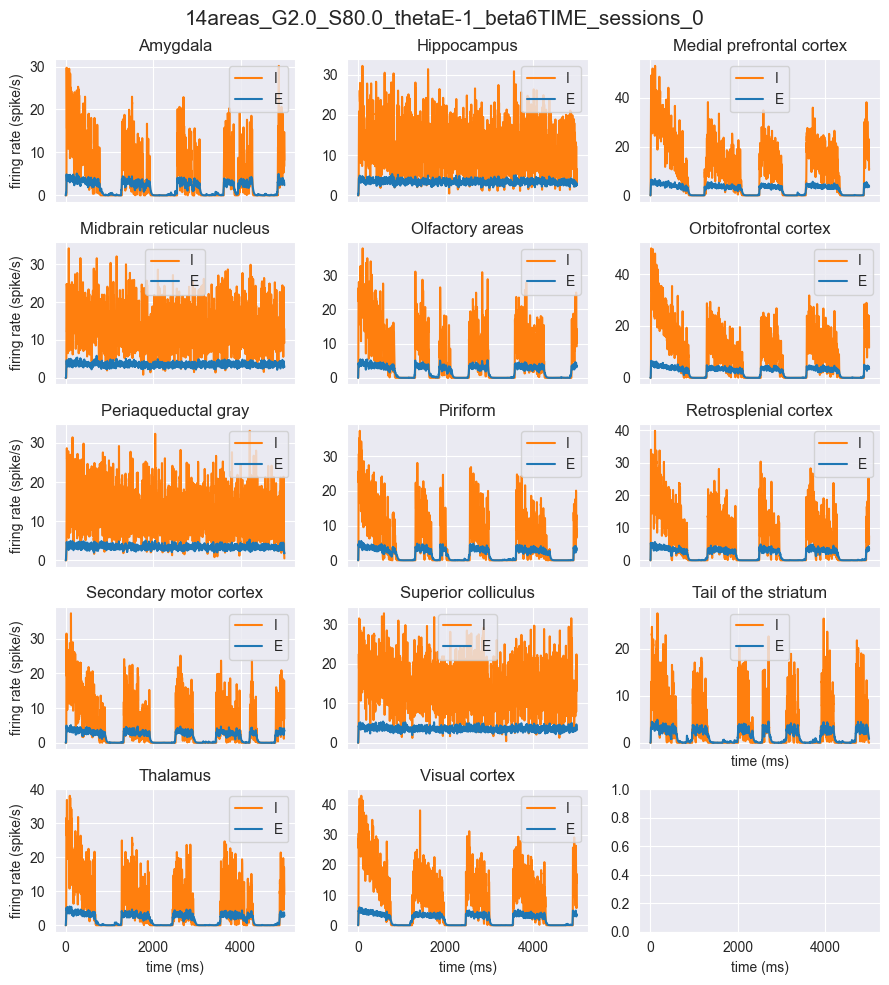

In [9]:
# plot one session
# plot signal of all regions for one simulation session
session = 0
G = 2
S = 80
beta = 6
thetaE = -1
extra = "TIME"
start = 0
stop = 5000
file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_sessions'
file_dir = os.path.join(output_dir, file_name)
file_name = file_name + f'_{session}'
plot_multiarea_signal(file_dir, file_name, start, stop, states=False, stimulation=False)

In [ ]:
# calculate the states and synchrony quantification (brunel X parameter) for many different G values 
G_parameters = np.arange(0, 4, 1)
all_analyses = pd.DataFrame()
brunel_X_df = pd.DataFrame()
for G in G_parameters:
    G_param = np.round(G, 1)
    file_name = f'14areas_G{G_param}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
    file_dir = os.path.join(output_dir, file_name)
    _ = get_all_states(file_dir, file_name)
    brunel_X_df = pd.concat((brunel_X_df, compute_brunel_x(file_dir, file_name)))
    all_analyses = pd.concat((all_analyses, compute_state_analysis(file_dir, file_name)))

In [42]:
G_params = np.arange(0, 4, 1)
S_params = [40, 0] #np.arange(0,240,40)
session_params = pd.DataFrame()
brunel_X_df = pd.DataFrame()
extra = "RateAdj1_sessions"
filename_out = ''
sessions = np.arange(10,20,1)
all_analyses = pd.DataFrame()

for G in G_params:
    for S in S_params:           
            
        for session in sessions:
            
            print(f"Run: S={S}, G={G}, session={session}")
            # load the file name
            session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
            file_dir = os.path.join(output_dir, session_name)
            file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_{session}'    
    
            # check if any files in the directory end with 'states.csv'
            if any(f.endswith(f'{session}_states.csv') for f in os.listdir(file_dir)):
                pass
            else:
                print('The folder does not contain a file with the ending "states.csv"')
                _ = get_all_states(file_dir, file_name)

Run: S=40, G=0, session=10
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=0, session=11
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=0, session=12
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=0, session=13
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=0, session=14
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=0, session=15
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=0, session=16
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=0, session=17
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=0, session=18
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=0, session=19
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=0, session=10
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=0, session=11
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=0, session=12
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=0, session=13
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=0, session=14
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=0, session=15
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=0, session=16
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=0, session=17
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=0, session=18
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=0, session=19
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=1, session=10
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=1, session=11
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=1, session=12
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=1, session=13
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=1, session=14
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=1, session=15
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=1, session=16
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=1, session=17
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=1, session=18
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=1, session=19
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=1, session=10
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=1, session=11
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=1, session=12
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=1, session=13
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=1, session=14
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=1, session=15
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=1, session=16
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=1, session=17
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:02<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=1, session=18
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=1, session=19
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=2, session=10
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=2, session=11
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=2, session=12
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=2, session=13
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=2, session=14
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=2, session=15
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=2, session=16
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=2, session=17
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=2, session=18
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=2, session=19
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=10
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=11
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=12
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=13
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=14
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=15
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=16
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=17
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=18
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=2, session=19
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=10
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=11
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=12
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=13
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=14
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=15
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=16
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=17
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=18
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=40, G=3, session=19
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=3, session=10
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=3, session=11
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=3, session=12
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=3, session=13
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=3, session=14
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=3, session=15
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=3, session=16
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=3, session=17
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=3, session=18
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Run: S=0, G=3, session=19
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [41]:
# compute the paramters of serotonin stimulation for different G and S values
G_params = [2]
S_params = [0] #np.arange(0,240,40)
session_params = pd.DataFrame()
brunel_X_df = pd.DataFrame()
extra = "RateAdj1_K_sessions"
filename_out = ''
sessions = np.arange(0,10,1)
all_analyses = pd.DataFrame()

for G in G_params:
    for S in S_params:           
            
        for session in sessions:
            print(f"Run: S={S}, G={G}, session={session}")
            # load the file name
            session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
            file_dir = os.path.join(output_dir, session_name)
            file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_{session}'
            all_analyses = pd.concat((all_analyses, compute_state_analysis(file_dir, file_name)))
            brunel_X_df = pd.concat((brunel_X_df, compute_brunel_x(file_dir, file_name)))
            session_params = pd.concat((session_params, compute_stimulation_parameter(file_dir, file_name, session=session)))

#brunel_X_df.to_csv(f'brunelX_all_sessions_{extra}{filename_out}.csv', index=False) 
#session_params.to_csv(f'serotonin_stimulation_analysis_all_sessions_{extra}{filename_out}.csv', index=False)

Run: S=0, G=2, session=0
The folder contains a file with the ending "states.csv"
Run: S=0, G=2, session=1
The folder contains a file with the ending "states.csv"
Run: S=0, G=2, session=2
The folder contains a file with the ending "states.csv"
Run: S=0, G=2, session=3
The folder contains a file with the ending "states.csv"
Run: S=0, G=2, session=4
The folder contains a file with the ending "states.csv"
Run: S=0, G=2, session=5
The folder contains a file with the ending "states.csv"
Run: S=0, G=2, session=6
The folder contains a file with the ending "states.csv"
Run: S=0, G=2, session=7
The folder contains a file with the ending "states.csv"
Run: S=0, G=2, session=8
The folder contains a file with the ending "states.csv"
Run: S=0, G=2, session=9
The folder contains a file with the ending "states.csv"


In [8]:
# compute the paramters of serotonin stimulation for different G and S values
G_params = [2]
S_params = [40] #np.arange(0,240,40)
session_params = pd.DataFrame()
brunel_X_df = pd.DataFrame()
extra = "RateAdj1_K_sessions"
filename_out = ''
sessions = np.arange(0,10,1)
all_analyses = pd.DataFrame()

for G in G_params:
    for S in S_params:           
            
        for session in sessions:
            print(f"Run: S={S}, G={G}, session={session}")
            # load the file name
            session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
            file_dir = os.path.join(output_dir, session_name)
            file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_{session}'
            all_analyses = pd.concat((all_analyses, compute_state_analysis(file_dir, file_name)))
            brunel_X_df = pd.concat((brunel_X_df, compute_brunel_x(file_dir, file_name)))
            session_params = pd.concat((session_params, compute_stimulation_parameter(file_dir, file_name, session=session)))

#brunel_X_df.to_csv(f'brunelX_all_sessions_{extra}{filename_out}.csv', index=False) 
#session_params.to_csv(f'serotonin_stimulation_analysis_all_sessions_{extra}{filename_out}.csv', index=False)

Run: S=40, G=2, session=0
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder contains a file with the ending "states.csv"
Run: S=40, G=2, session=1
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder contains a file with the ending "states.csv"
Run: S=40, G=2, session=2
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder contains a file with the ending "states.csv"
Run: S=40, G=2, session=3
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder contains a file with the ending "states.csv"
Run: S=40, G=2, session=4
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder contains a file with the ending "states.csv"
Run: S=40, G=2, session=5
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder contains a file with the ending "states.csv"
Run: S=40, G=2, session=6
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder contains a file with the ending "states.csv"
Run: S=40, G=2, session=7
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder contains a file with the ending "states.csv"
Run: S=40, G=2, session=8
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder contains a file with the ending "states.csv"
Run: S=40, G=2, session=9
The folder does not contain a file with the ending "states.csv"


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

The folder contains a file with the ending "states.csv"


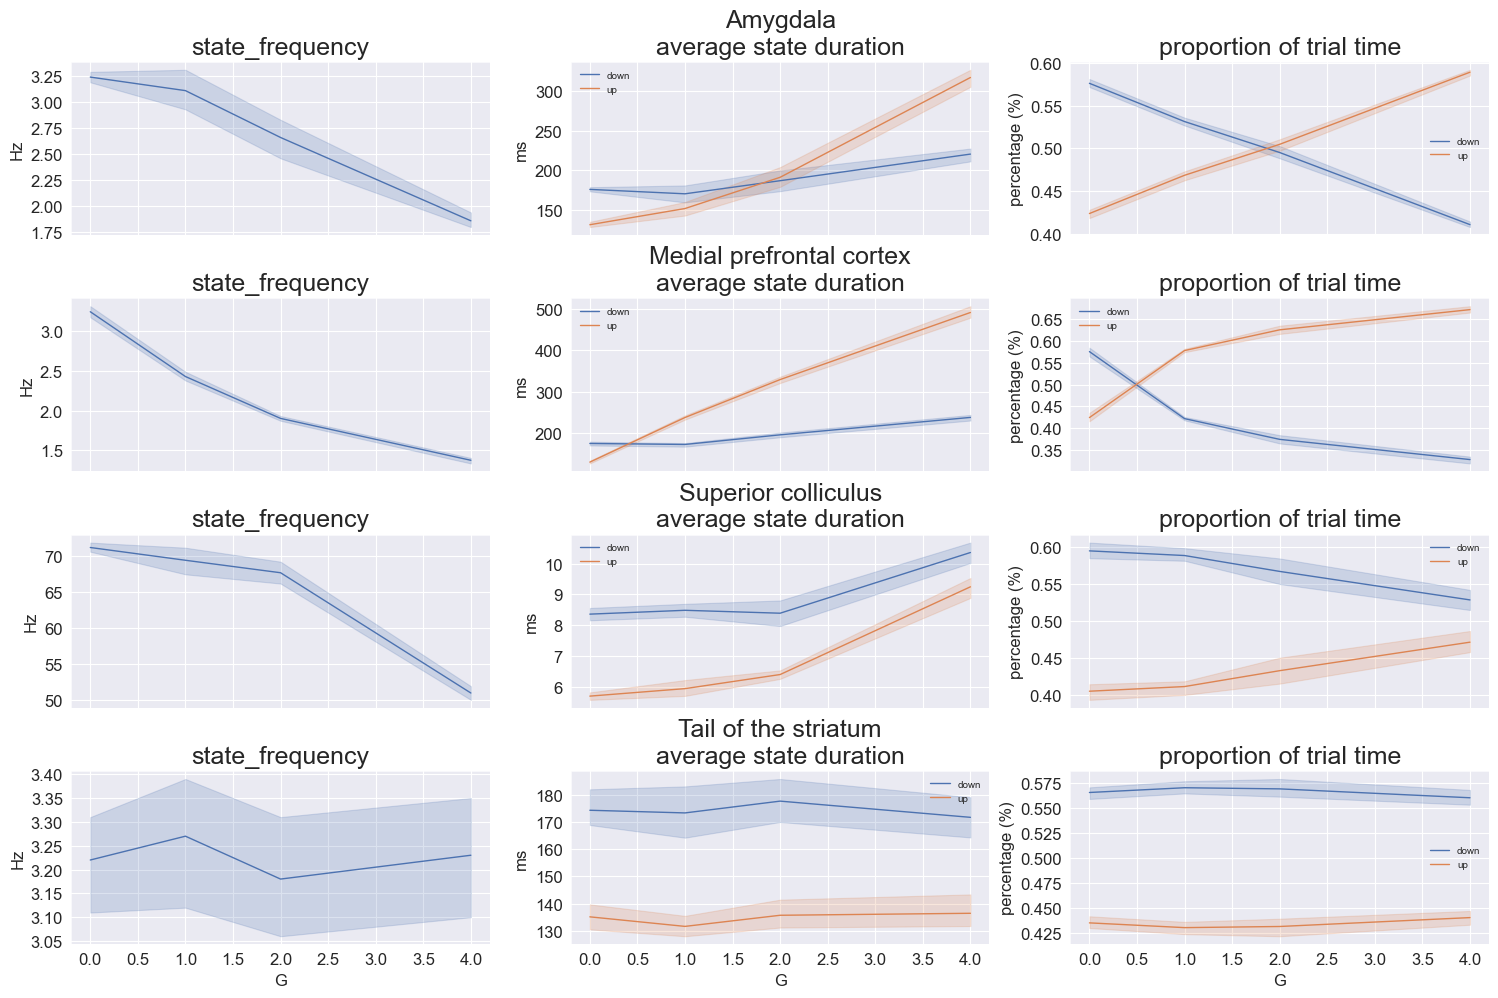

In [627]:
# plot state analysis (with error bars)
plot_parameter_statistics(all_analyses, regions=['Amygdala', 'Medial prefrontal cortex',
                                                 'Tail of the striatum', 'Superior colliculus'],
                                                  size=[15,10], savefig=False, filename_out='')

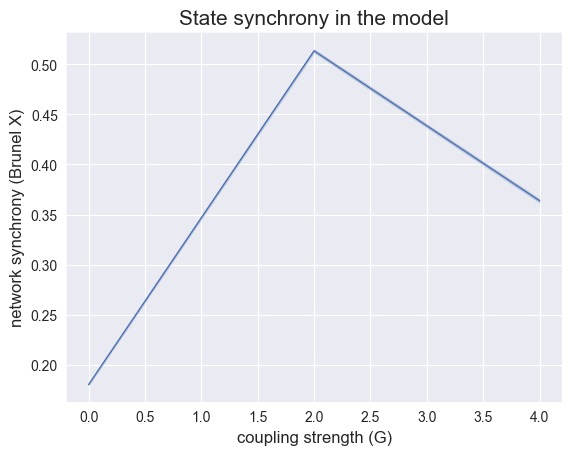

In [606]:
# plot the brunel X synchrony with errorbars
extra = 'NewDRN_C_sessions'
filename_out = ''
brunel_X_df = pd.read_csv(f'brunelX_all_sessions_{extra}{filename_out}.csv')

# calculate the states and synchrony quantification (brunel X parameter) for many different G values 
no_stim_data = brunel_X_df[brunel_X_df['S']==0]
sns.lineplot(no_stim_data, x='G', y='brunel_X')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('coupling strength (G)', fontsize=12)
plt.ylabel('network synchrony (Brunel X)', fontsize=12)
plt.title('State synchrony in the model', fontsize=15)
plt.savefig(os.path.join(fig_path, f'brunel_x_{extra}.jpg'), transparent=False)
plt.show()

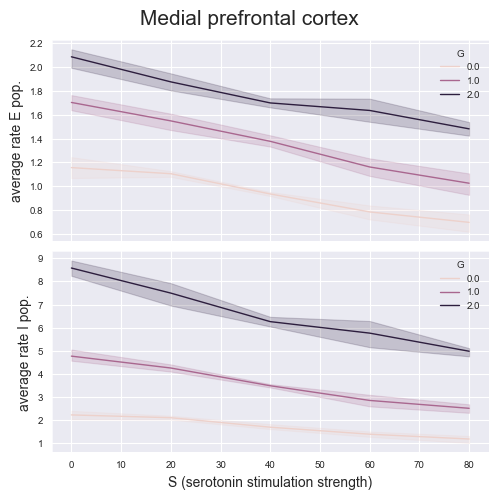

In [70]:
plot_mean_stimulation(f'serotonin_stimulation_analysis_all_sessions_{extra}{filename_out}', 'Medial prefrontal cortex', [0, 1,2])

In [ ]:
# plot the mean firing rate (E and I) during serotonin stimulation for different G (different graphs in one plot) 
# and S values (on the x axis)

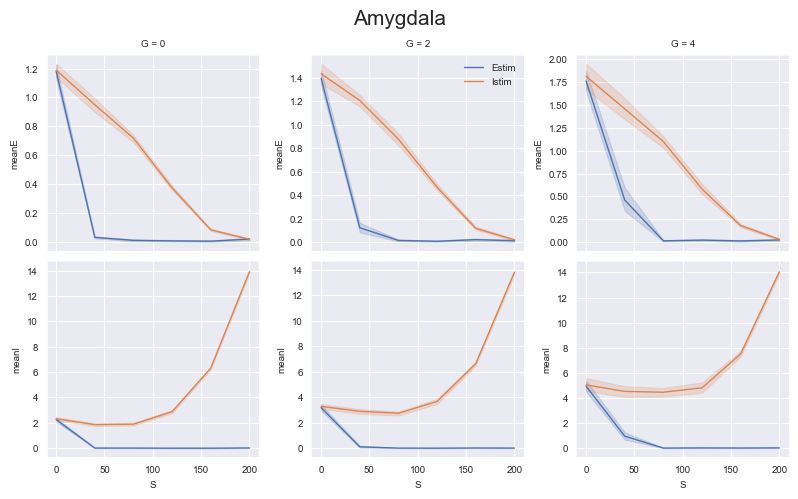

In [591]:
filename_E = 'serotonin_stimulation_analysis_all_sessions_NewDRN_sessions' + '.csv'
filename_I = 'serotonin_stimulation_analysis_all_sessions_NewDRN_I_sessions' + '.csv'
G_params = [0, 2, 4]
S_params = np.arange(0,240,40)

plot_compare_stimTarget(filename_E, filename_I, 'Amygdala', G_params, S_params, savefig=True)

### Transitions between up and down states

In [59]:
# compute the transitions (p state change and p down/up)
region = [13]
window_duration = 3000
pre_stim = 1000
sessions = np.arange(0, 5, 1)
extra = 'RateAdj1'
mean_transition_windows = compute_transitions([0,1,2], [0, 40, 80], region, window_duration, pre_stim, sessions=sessions, extra=extra)

0
1
2


C:\Users\gross\AppData\Local\Temp\ipykernel_37012\2902006883.py:697: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data_grouped_S, x='time', y='p_down', hue='S', ax=axes[i], palette='deep')


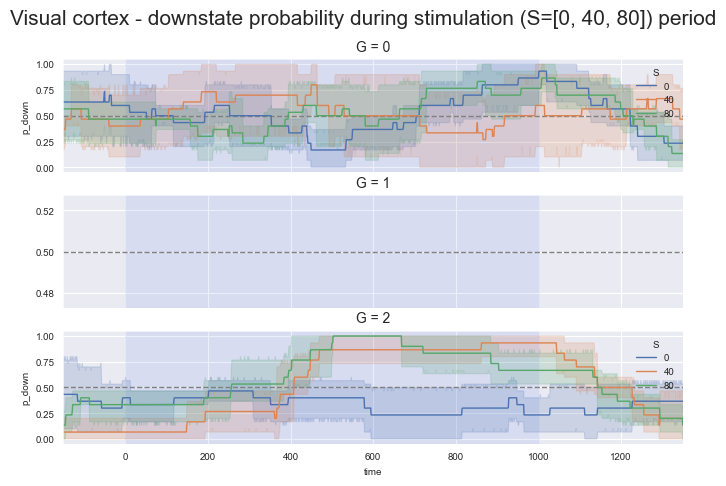

In [60]:
# plot the probablility of a down state in a certain region
plot_downstate_prob(mean_transition_windows, S=[0, 40, 80], G_params=[0,1,2], region=region[0], savefig=True, fileout=extra)

digitized shape (3000,)
33000


ValueError: Length of values (12000) does not match length of index (33000)

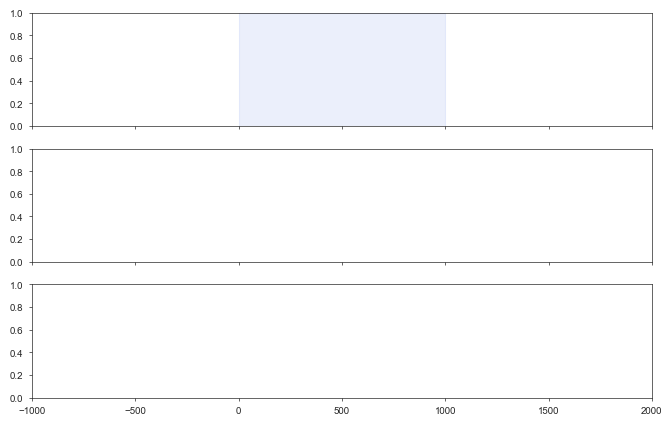

In [377]:
bin_size = 50
S = 160
pre_stim = 1000
G_plot = [0, 1, 2]
plot_statechange_prob(mean_transition_windows, bin_size, S, G_plot, pre_stim, False)

### Plots for comparison to neuropixel recordings 


In [26]:
fig_path = 'Figures/thesis_figures'

In [27]:
# summarize regions according to this combinations 
frontal = ['Medial prefrontal cortex', 'Orbitofrontal cortex', 'Secondary motor cortex'] # = 'Frontal'
sensory = ['Piriform', 'Visual cortex'] # = 'Sensory'
midbrain = ['Periaqueductal gray', 'Midbrain reticular nucleus', 'Superior colliculus'] # = 'Midbrain'
relevant_area_IDs = [0, 1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13]

# compute the state transition data (p state change and p down/up)
window_duration = 4500
pre_stim = 1000
G = [2]
S = [0, 40]
sessions = np.arange(0, 10, 1)
extra = 'RateAdj1'
state_transitions = compute_transitions(G, S, relevant_area_IDs, window_duration, 
                                              pre_stim, sessions=sessions, extra=extra)

# calc prob of up state
state_transitions['p_up'] = 1-state_transitions['p_down']

# and the prob of any state change, which equals adding prob. of down->up and up-> down 
state_transitions['p_state_change'] = state_transitions['p_state_change_up'] + state_transitions['p_state_change_down']

In [28]:
# combine regions 
state_transitions['combined_region'] = state_transitions['region_name']
state_transitions['combined_region'].iloc[np.where(state_transitions['region_name'].isin(frontal))] = 'Frontal cortex' 
state_transitions['combined_region'].iloc[np.where(state_transitions['region_name'].isin(sensory))] = 'Sensory cortex' 
state_transitions['combined_region'].iloc[np.where(state_transitions['region_name'].isin(midbrain))] = 'Midbrain' 
# take the mean for the combined regions 
state_transitions = state_transitions.groupby(['combined_region', 'S', 'session', 'G', 'time'], as_index=False).mean()

# compute bins
# for this find how many sessions there are in this set and how long one session is 
bin_size = 200
nr_sessions = len(np.unique(state_transitions['session']))
print('sessions', nr_sessions)
max_time = len(np.unique(state_transitions['time']))
nr_bins = max_time/bin_size
bins = np.linspace(-pre_stim, max_time-pre_stim, int(nr_bins), endpoint=False)
print('max time', max_time)
print('bins', len(bins))

# also find how many regions we have in this data frame
regions_plot = []
regions_plot = np.unique(state_transitions['combined_region'])

# compute the time points of the bins
digitized = np.digitize(np.unique(state_transitions['time']), bins, right=True)
state_transitions['bin'] = np.tile(digitized, nr_sessions*len(regions_plot)*len(S))


C:\Users\gross\AppData\Local\Temp\ipykernel_9844\3744957791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_transitions['combined_region'].iloc[np.where(state_transitions['region_name'].isin(frontal))] = 'Frontal cortex'
C:\Users\gross\AppData\Local\Temp\ipykernel_9844\3744957791.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_transitions['combined_region'].iloc[np.where(state_transitions['region_name'].isin(sensory))] = 'Sensory cortex'
C:\Users\gross\AppData\Local\Temp\ipykernel_9844\3744957791.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

sessions 10
max time 4500
bins 22


Todo:
- do the same for a lower G value
- do the same for a lower G without adaptation
- do the same for adjusted firing rates


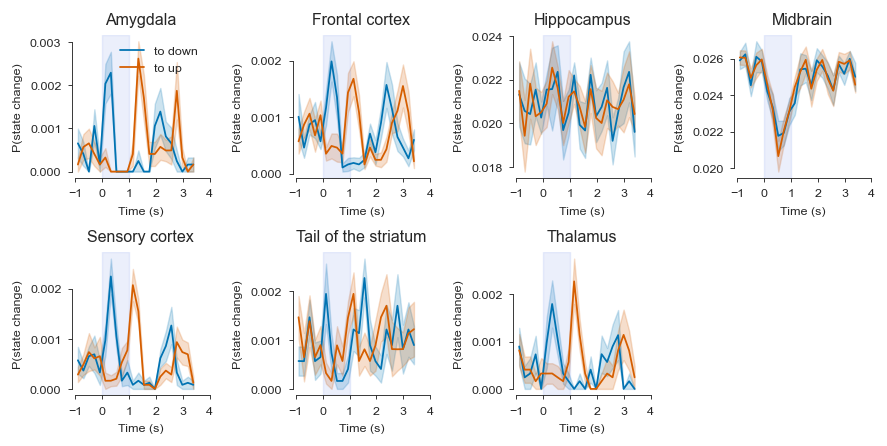

In [29]:
colors, dpi = figure_style()
f, axs = plt.subplots(2, 4, figsize=(7, 3.5), dpi=dpi)
axs = np.concatenate(axs)

baseline_data = state_transitions[state_transitions['S']==0]
baseline_grouped_bins = baseline_data.groupby(['combined_region', 'session', 'bin', 'window'], as_index=False).mean()
baseline_grouped_bins['time'] = baseline_grouped_bins['time']/1000

stimulation_data = state_transitions[state_transitions['S']>0]
data_grouped_bins = stimulation_data.groupby(['combined_region', 'session', 'bin', 'window'], as_index=False).mean()
data_grouped_bins['time'] = data_grouped_bins['time']/1000

for i, region in enumerate(regions_plot):
    
    region_data = data_grouped_bins[data_grouped_bins['combined_region'] == region]
    region_data = region_data[region_data['time'] > -0.95]
    
    axs[i].axvspan(0, 1, alpha=0.1, color='royalblue')
    sns.lineplot(data=region_data, x='time', y='p_state_change_down',
                 color=colors['suppressed'], errorbar='se', ax=axs[i], label='to down')
    sns.lineplot(data=region_data, x='time', y='p_state_change_up',
                 color=colors['enhanced'], errorbar='se', ax=axs[i], label='to up')
    axs[i].set(ylabel='P(state change)', xlabel='Time (s)', title=region, xticks=[-1, 0, 1, 2, 3, 4])
    axs[i].set_title(region, fontsize=9)
    #handles, labels = axs[i].get_legend_handles_labels()
    #plt.legend(handles, labels,bbox_to_anchor=(-0, 0))
    axs[i].legend(loc='best')
    if i >0:
        axs[i].get_legend().remove()
    
axs[-1].axis('off')
plt.tight_layout()
sns.despine(trim=True)

plt.savefig(os.path.join(fig_path, f'p_state_change_anesthesia_{extra}_{S}_{G}.jpg'), dpi=600)

NameError: name 'data_grouped_bins' is not defined

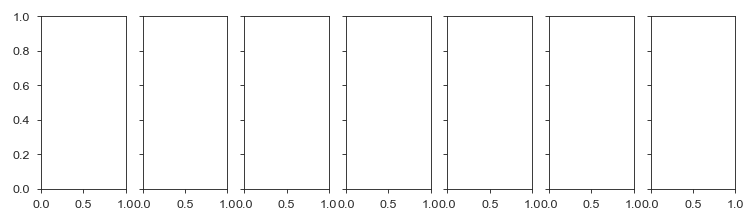

In [23]:
# replication of the p_state_anesthesia plot (showing prob. of up and down states)

# %% Plot
colors, dpi = figure_style()
colors['down-state'] =  sns.color_palette('colorblind')[3]
f, axs = plt.subplots(1, 7, figsize=(7, 1.75), dpi=dpi, sharey=True)
#axs = np.concatenate(axs)
regions = ['Frontal cortex', 'Amygdala',  'Tail of the striatum', 'Sensory cortex', 
           'Hippocampus', 'Thalamus','Midbrain']
p_state_df = data_grouped_bins # [data_grouped_bins['window']==0]
baseline_df = baseline_grouped_bins

for i, region in enumerate(regions):
    
    axs[i].axvspan(0, 1, alpha=0.25, color='royalblue', lw=0)
    #axs[i].add_patch(Rectangle((0, 0), 1, 1, color='royalblue', alpha=0.25, lw=0))
    
    axs[i].plot([-1, 3], [0.5, 0.5], ls='--', color='grey')
    sns.lineplot(data=p_state_df[p_state_df['combined_region'] == region], x='time', y='p_down',
                 color=colors['suppressed'], errorbar='se', err_kws={'lw': 0}, ax=axs[i])
    sns.lineplot(data=baseline_df[baseline_df['combined_region'] == region], x='time', y='p_down',
                 color=colors['grey'], errorbar='se', ax=axs[i], label='baseline')
    axs[i].set(xlabel='Time (s)', title=region, ylim=[-0.02, 1],
               yticks=[0, 0.5, 1], yticklabels=[0, 50, 100])
    axs[i].set_title(region, fontsize=10)
    
    if i == 0:
        axs[i].set_ylabel('Down state probability (%)')
        axs[i].get_xaxis().set_visible(False)
        sns.despine(trim=True, bottom=True, ax=axs[i])
        axs[i].plot([0, 2], [-0.01, -0.01], color='k', lw=0.5)
        axs[i].text(1, -0.03, '2s', ha='center', va='top')
    else:
        axs[i].get_yaxis().set_visible(False)
        axs[i].axis('off')
    
    if i < 6:
        axs[i].get_legend().remove()
        
plt.subplots_adjust(left=0.08, bottom=0.15, right=1, top=0.85, wspace=0, hspace=0.4)
plt.tight_layout(h_pad=-10, w_pad=1.08)
plt.savefig(os.path.join(fig_path, f'p_state_anesthesia_{extra}_{S}_{G}.jpg'), dpi=600)

C:\Users\gross\AppData\Local\Temp\ipykernel_9844\4134702285.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_stimulation['p_down_delta'] = no_stimulation['p_down'] - mean_baseline
C:\Users\gross\AppData\Local\Temp\ipykernel_9844\4134702285.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulation['p_down_delta'] = stimulation['p_down'] - mean_baseline - no_stimulation['p_down_delta']
C:\Users\gross\AppData\Local\Temp\ipykernel_9844\4134702285.py:26: SettingWithCopyWarning: 
A value is trying t

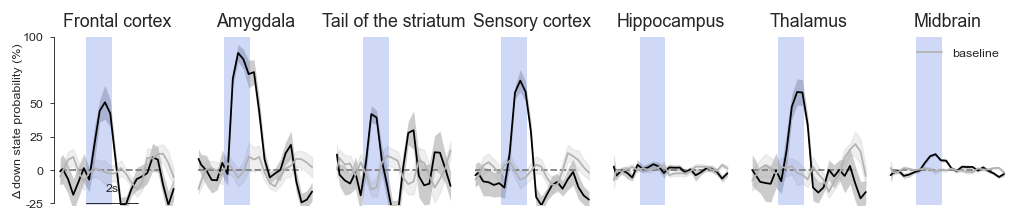

In [30]:
# DELTA DOWNSTATE PROBABILITY
# same plot as above, with subtracted baseline and baseline around 0 

# %% Plot
colors, dpi = figure_style()
colors['down-state'] =  sns.color_palette('colorblind')[3]
colors['stim'] = [0, 0, 0]
colors['no-stim'] = [0.7, 0.7, 0.7]
f, axs = plt.subplots(1, 7, figsize=(8, 1.75), dpi=dpi, sharey=True)
#axs = np.concatenate(axs)
regions = ['Frontal cortex', 'Amygdala',  'Tail of the striatum', 'Sensory cortex', 
           'Hippocampus', 'Thalamus','Midbrain']
p_state_df = data_grouped_bins # [data_grouped_bins['window']==0]
baseline_df = baseline_grouped_bins

for i, region in enumerate(regions):
    
    axs[i].axvspan(0, 1, alpha=0.25, color='royalblue', lw=0)
    #axs[i].add_patch(Rectangle((0, 0), 1, 1, color='royalblue', alpha=0.25, lw=0))
    
    axs[i].plot([-1, 3], [0, 0], ls='--', color='grey')
    
    stimulation = p_state_df[p_state_df['combined_region'] == region]
    no_stimulation = baseline_df[baseline_df['combined_region'] == region]
    mean_baseline = np.mean(no_stimulation['p_down'])
    no_stimulation['p_down_delta'] = no_stimulation['p_down'] - mean_baseline
    stimulation['p_down_delta'] = stimulation['p_down'] - mean_baseline - no_stimulation['p_down_delta']
    
    sns.lineplot(data=stimulation, x='time', y='p_down_delta',
                 color=colors['stim'], errorbar='se', err_kws={'lw': 0}, ax=axs[i])
    sns.lineplot(data=no_stimulation, x='time', y='p_down_delta',
                 color=colors['no-stim'], errorbar='se', ax=axs[i], label='baseline')
    axs[i].set(xlabel='Time (s)', title=region, ylim=[-0.265, 0.5],
               yticks=[-0.25, 0, 0.25, 0.5, 1], yticklabels=[-25, 0, 25, 50, 100])
    axs[i].set_title(region, fontsize=10)
    
    if i == 0:
        #axs[i].set_ylabel('Down state probability (%)', fontsize=8)
        axs[i].set_ylabel(u'Δ down state probability (%)', labelpad=0)
        axs[i].get_xaxis().set_visible(False)
        sns.despine(trim=True, bottom=True, ax=axs[i])
        axs[i].plot([0, 2], [-0.25, -0.25], color='k', lw=0.5)
        axs[i].text(1, -0.1, '2s', ha='center', va='top')
    else:
        axs[i].get_yaxis().set_visible(False)
        axs[i].axis('off')
    
    if i < 6:
        axs[i].get_legend().remove()

plt.subplots_adjust(left=0.08, bottom=0.15, right=1, top=0.85, wspace=0, hspace=0.4)
plt.tight_layout(h_pad=-10, w_pad=1.08)
#plt.savefig(os.path.join(fig_path, f'p_state_anesthesia_nullbaseline{extra}_{S}_{G}.jpg'), dpi=600)

### Adjust frequency with time constant


In [48]:
# compute state frequencies

# compute the paramters of serotonin stimulation for different G and S values
session_params = pd.DataFrame()
brunel_X_df = pd.DataFrame()
thetaE= -1
beta = 6
sessions = [0] # np.arange(0,5,1)
all_analyses = pd.DataFrame()
time_params = np.arange(1,4,0.5)
extra = 'RateAdj1'
G = 2
S = 0

for time_scale in time_params:
    extra = f"_{time_scale}time_sessions"
    for session in sessions:
        print(f"Run: S={S}, G={G}, session={session}")
        # load the file name
        session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
        file_dir = os.path.join(output_dir, session_name)
        file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_{session}'
        firing_rates = load_firing_rates(file_dir, file_name)
        
        # compute mean E and I firing rates
        meanI = np.mean(firing_rates[1], axis=0)
        meanE = np.mean(firing_rates[0], axis=0)
        
        table = compute_state_analysis(file_dir, file_name)
        table['time_scale'] = time_scale
        table['meanE'] = meanE
        table['meanI'] = meanI
        
        all_analyses = pd.concat((all_analyses, table))
        

Run: S=0, G=2, session=0
Run: S=0, G=2, session=0
Run: S=0, G=2, session=0
Run: S=0, G=2, session=0
Run: S=0, G=2, session=0
Run: S=0, G=2, session=0


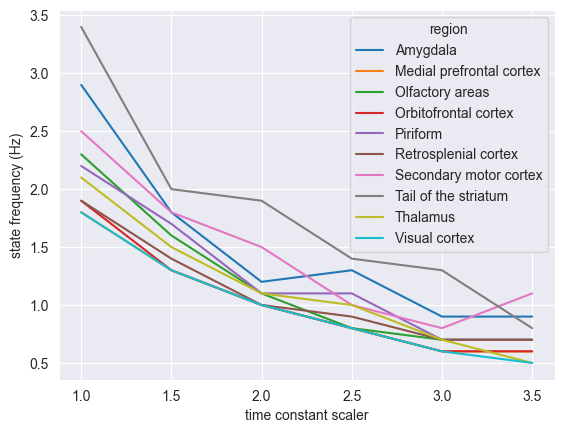

In [29]:
all_analyses_states = all_analyses[~all_analyses['region'].isin(['Hippocampus', 'Midbrain reticular nucleus', 'Periaqueductal gray', 'Superior colliculus'])]
sns.lineplot(all_analyses_states, x='time_scale', y='state_frequency', hue='region')
plt.xlabel('time constant scaler')
plt.ylabel('state frequency (Hz)')
plt.savefig(f'timescaler_G{G}_S{S}.jpg')

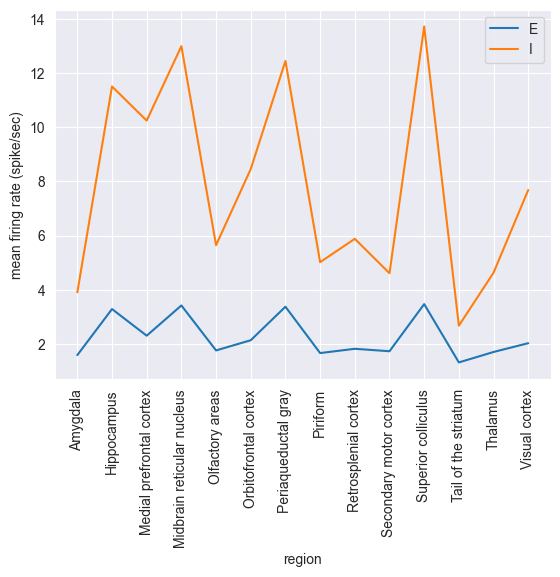

In [57]:
# plot mean I and E firing rates
mean_data = all_analyses[all_analyses['time_scale']==3.0]
sns.lineplot(mean_data, x='region', y='meanE', label='E')
sns.lineplot(mean_data, x='region', y='meanI', label='I')
plt.xticks(mean_data['region'], rotation=90)
plt.ylabel("mean firing rate (spike/sec)")
plt.show()

### Adjusted firing rates with Islope and Eslope parameter

In [45]:
# compute the paramters of serotonin stimulation for different G and S values
G_params = [2]
S_params = [0] #np.arange(0,240,40)
session_params = pd.DataFrame()
brunel_X_df = pd.DataFrame()
extra = "RateAdj1_sessions"
filename_out = ''
sessions = [0]# np.arange(0,5,1)
all_analyses = pd.DataFrame()

for G in G_params:
    for S in S_params:           
        for session in sessions:
            print(f"Run: S={S}, G={G}, session={session}")
            # load the file name
            session_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}'
            file_dir = os.path.join(output_dir, session_name)
            file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_{session}'
            table = compute_state_analysis(file_dir, file_name)
            # compute mean E and I firing rates
            firing_rates = load_firing_rates(file_dir, file_name)
            meanI = np.mean(firing_rates[1], axis=0)
            meanE = np.mean(firing_rates[0], axis=0)
            table['meanE'] = meanE
            table['meanI'] = meanI
            all_analyses = pd.concat((all_analyses, table))
            brunel_X_df = pd.concat((brunel_X_df, compute_brunel_x(file_dir, file_name)))
            session_params = pd.concat((session_params, compute_stimulation_parameter(file_dir, file_name, session=session)))

brunel_X_df.to_csv(f'brunelX_all_sessions_{extra}{filename_out}.csv', index=False) 
session_params.to_csv(f'serotonin_stimulation_analysis_all_sessions_{extra}{filename_out}.csv', index=False)

Run: S=0, G=2, session=0
The folder contains a file with the ending "states.csv"


In [93]:
all_analyses

,state_frequency,d_down,d_up,p_down,p_up,region,G,S,session,meanE,meanI
0,1.00,516.666667,457.500000,0.54250,0.45750,Amygdala,0.0,0.0,0,1.269328,2.540659
0,20.15,24.089330,25.538462,0.48540,0.51460,Hippocampus,0.0,0.0,0,3.070768,6.548971
0,1.25,325.461538,461.520000,0.42310,0.57690,Medial prefrontal cortex,0.0,0.0,0,1.566118,4.945916
0,22.85,22.461707,21.301969,0.51325,0.48675,Midbrain reticular nucleus,0.0,0.0,0,3.688104,12.149214
0,1.20,387.440000,429.750000,0.48430,0.51570,Olfactory areas,0.0,0.0,0,1.493859,4.287749
...,...,...,...,...,...,...,...,...,...,...,...
0,0.80,427.588235,795.687500,0.36345,0.63655,Secondary motor cortex,3.0,80.0,0,2.045596,7.304472
0,25.20,21.310891,18.329365,0.53810,0.46190,Superior colliculus,3.0,80.0,0,3.791140,15.862624
0,0.85,638.500000,500.411765,0.57465,0.42535,Tail of the striatum,3.0,80.0,0,1.334233,2.763491
0,0.50,739.363636,1186.700000,0.40665,0.59335,Thalamus,3.0,80.0,0,1.990170,6.613739


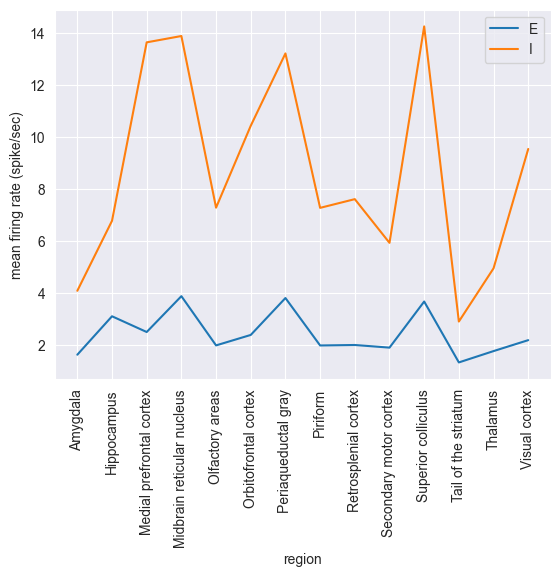

In [97]:
# plot mean I and E firing rates
mean_data_ad = all_analyses[all_analyses['G']==2]
mean_data_ad = mean_data_ad[mean_data_ad['S']==0]
sns.lineplot(mean_data_ad, x='region', y='meanE', label='E')
sns.lineplot(mean_data_ad, x='region', y='meanI', label='I')
plt.xticks(mean_data['region'], rotation=90)
plt.ylabel("mean firing rate (spike/sec)")
plt.show()

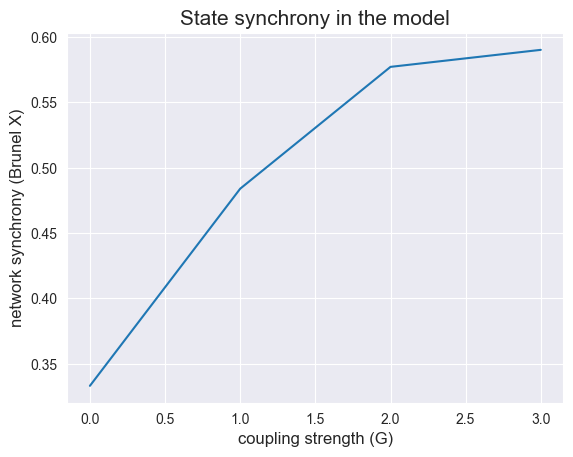

In [95]:
# plot the brunel X synchrony with errorbars
extra = 'RateAdj_sessions'
filename_out = ''
brunel_X_df = pd.read_csv(f'brunelX_all_sessions_{extra}{filename_out}.csv')

# calculate the states and synchrony quantification (brunel X parameter) for many different G values 
no_stim_data = brunel_X_df[brunel_X_df['S']==0]
sns.lineplot(no_stim_data, x='G', y='brunel_X')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('coupling strength (G)', fontsize=12)
plt.ylabel('network synchrony (Brunel X)', fontsize=12)
plt.title('State synchrony in the model', fontsize=15)
plt.savefig(os.path.join(fig_path, f'brunel_x_{extra}.jpg'), transparent=False)
plt.show()

The folder contains a file with the ending "states.csv"


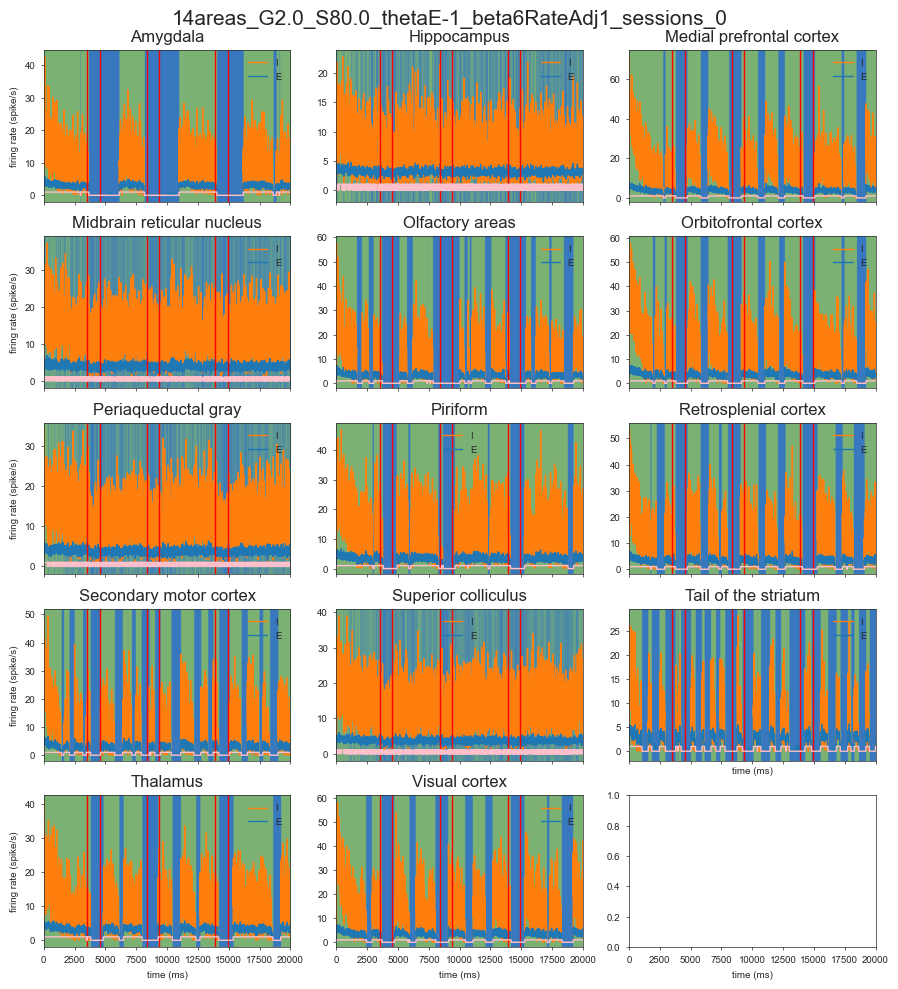

In [25]:
# plot one session
# plot signal of all regions for one simulation session
session = 0
G = 2
S = 80
beta = 6
thetaE = -1
extra = "RateAdj1"
start = 0
stop = 5000
file_name = f'14areas_G{float(G)}_S{float(S)}_thetaE{thetaE}_beta{beta}{extra}_sessions'
file_dir = os.path.join(output_dir, file_name)
file_name = file_name + f'_{session}'
plot_multiarea_signal(file_dir, file_name, start, states=True, stimulation=True)

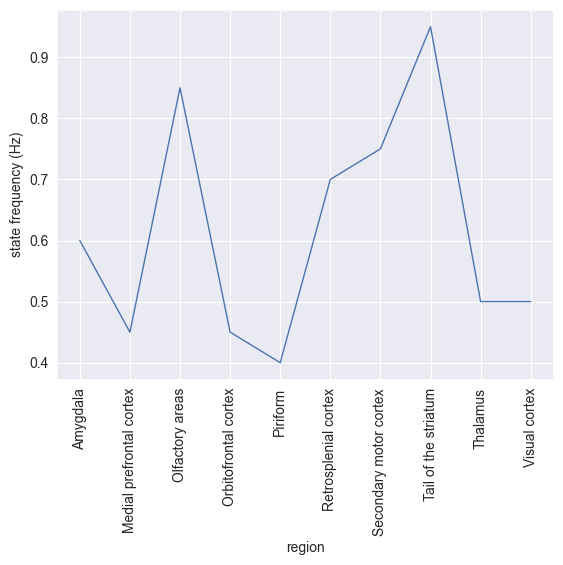

In [56]:
freq_data = all_analyses[~all_analyses['region'].isin(['Hippocampus', 'Midbrain reticular nucleus', 'Periaqueductal gray', 'Superior colliculus'])]
sns.lineplot(freq_data, x='region', y='state_frequency')
plt.xticks(freq_data['region'], rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("state frequency (Hz)", fontsize=10)
plt.xlabel("region", fontsize=10)
plt.show()